In [1]:
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
import muon as md
import pandas as pd
import plotnine as p9
from matplotlib import pyplot as plt
import decoupler as dc
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import re

In [2]:
sc._settings.ScanpyConfig.n_jobs = 4

## Import

### Read in 

In [3]:
mdata = md.read_h5mu("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr02.h5mu")
print(mdata)
rna = mdata["rna"]

MuData object with n_obs × n_vars = 42903 × 32303
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
  3 modalities
    rna:	42903 x 32286
      var:	'gene_ids', 'feature_types', 'genome'
    guide:	42903 x 12
      var:	'gene_ids', 'feature_types', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'
    cite:	42903 x 5
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'


In [4]:
guides = pd.read_csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/protospacer_calls_per_cell.csv", index_col=0)
print(guides.head())

rna.obs = rna.obs.join(guides)

rna = rna[~rna.obs.feature_call.isna(), :]

                    num_features          feature_call    num_umis
cell_barcode                                                      
AAACCAAAGATGAAGC-1             1                 NCC.1         313
AAACCAAAGCGAGTAG-1             3  NCC.1|NTC.1|Tgfbr2.3  753|44|393
AAACCAGCAACAAGAT-1             1                 NCC.1         179
AAACCATTCATCTCCG-1             1                 NCC.1          15
AAACCATTCGTCGCTC-1             2           NCC.1|NCC.2      76|172


### Label guides

In [5]:
def assign_guide(stri):
    if re.search(r"(?=.*Ifngr)(?=.*Tgfbr)", stri):
        return "double_KO"

    if "|" in stri:
        if re.search(r"Ifngr.+", stri):
            return "Ifngr1"
        elif re.search(r"Tgfbr.+", stri):
            return "Tgfbr2"
        else:
            return "double_control"

    else:
        return stri.split(".")[0]
        
rna.obs["guide"] = rna.obs.feature_call.map(assign_guide)

rna.obs

/tmp/ipykernel_1793716/1587943151.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


,num_features,feature_call,num_umis,guide
AAACCAAAGAAAGGTC-1,2.0,NTC.2|Ifngr1.1,18|50,Ifngr1
AAACCAAAGAAGGCGC-1,4.0,NTC.1|Ifngr1.2|Ifngr1.3|Tgfbr2.2,327|16|57|403,double_KO
AAACCAAAGACCCGAT-1,3.0,Ifngr1.1|Ifngr1.3|Tgfbr2.2,101|146|169,double_KO
AAACCAAAGACGTTAT-1,1.0,Tgfbr2.1,64,Tgfbr2
AAACCAAAGATGAAGC-1,1.0,NCC.1,313,NCC
...,...,...,...,...
GTTGTGGGTACCATCC-1,2.0,Ifngr1.1|Tgfbr2.3,433|337,double_KO
GTTGTGGGTCAAAGGA-1,4.0,NTC.1|Ifngr1.3|Ifngr1.4|Tgfbr2.1,15|96|38|425,double_KO
GTTGTGGGTCATGGGC-1,3.0,NCC.1|Ifngr1.1|Tgfbr2.2,39|137|83,double_KO
GTTGTGGGTCCGTGTT-1,1.0,Tgfbr2.1,94,Tgfbr2


### Label perturbations

In [6]:
def assign_perturbation(stri):

    if stri in ["NCC", "NTC", "double_control"]:
        return "NP"
    else:
        return stri + "_KO"

rna.obs["perturbation"] = rna.obs.guide.map(assign_perturbation)

rna.obs

,num_features,feature_call,num_umis,guide,perturbation
AAACCAAAGAAAGGTC-1,2.0,NTC.2|Ifngr1.1,18|50,Ifngr1,Ifngr1_KO
AAACCAAAGAAGGCGC-1,4.0,NTC.1|Ifngr1.2|Ifngr1.3|Tgfbr2.2,327|16|57|403,double_KO,double_KO_KO
AAACCAAAGACCCGAT-1,3.0,Ifngr1.1|Ifngr1.3|Tgfbr2.2,101|146|169,double_KO,double_KO_KO
AAACCAAAGACGTTAT-1,1.0,Tgfbr2.1,64,Tgfbr2,Tgfbr2_KO
AAACCAAAGATGAAGC-1,1.0,NCC.1,313,NCC,NP
...,...,...,...,...,...
GTTGTGGGTACCATCC-1,2.0,Ifngr1.1|Tgfbr2.3,433|337,double_KO,double_KO_KO
GTTGTGGGTCAAAGGA-1,4.0,NTC.1|Ifngr1.3|Ifngr1.4|Tgfbr2.1,15|96|38|425,double_KO,double_KO_KO
GTTGTGGGTCATGGGC-1,3.0,NCC.1|Ifngr1.1|Tgfbr2.2,39|137|83,double_KO,double_KO_KO
GTTGTGGGTCCGTGTT-1,1.0,Tgfbr2.1,94,Tgfbr2,Tgfbr2_KO


In [7]:
rna.obs.perturbation.value_counts()

perturbation
Tgfbr2_KO       16113
double_KO_KO     7455
Ifngr1_KO        7137
NP               6232
Name: count, dtype: int64

## Preprocessing

### Doublet removal

In [8]:
sc.pp.scrublet(rna)

In [9]:
rna.obs

,num_features,feature_call,num_umis,guide,perturbation,doublet_score,predicted_doublet
AAACCAAAGAAAGGTC-1,2.0,NTC.2|Ifngr1.1,18|50,Ifngr1,Ifngr1_KO,0.134490,False
AAACCAAAGAAGGCGC-1,4.0,NTC.1|Ifngr1.2|Ifngr1.3|Tgfbr2.2,327|16|57|403,double_KO,double_KO_KO,0.101075,False
AAACCAAAGACCCGAT-1,3.0,Ifngr1.1|Ifngr1.3|Tgfbr2.2,101|146|169,double_KO,double_KO_KO,0.122490,False
AAACCAAAGACGTTAT-1,1.0,Tgfbr2.1,64,Tgfbr2,Tgfbr2_KO,0.109784,False
AAACCAAAGATGAAGC-1,1.0,NCC.1,313,NCC,NP,0.170086,False
...,...,...,...,...,...,...,...
GTTGTGGGTACCATCC-1,2.0,Ifngr1.1|Tgfbr2.3,433|337,double_KO,double_KO_KO,0.070147,False
GTTGTGGGTCAAAGGA-1,4.0,NTC.1|Ifngr1.3|Ifngr1.4|Tgfbr2.1,15|96|38|425,double_KO,double_KO_KO,0.148585,False
GTTGTGGGTCATGGGC-1,3.0,NCC.1|Ifngr1.1|Tgfbr2.2,39|137|83,double_KO,double_KO_KO,0.064615,False
GTTGTGGGTCCGTGTT-1,1.0,Tgfbr2.1,94,Tgfbr2,Tgfbr2_KO,0.023652,False


- wow, no doublets

In [10]:
rna.obs = rna.obs.drop(columns = ["doublet_score", "predicted_doublet"])

### Normalization and Scaling

In [11]:
rna.layers["counts"] = rna.X.copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.scale(rna, max_value=10)

## Zscore DE genes

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2


/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 32286 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.


categories: Ifngr1_KO, NP, Tgfbr2_KO, etc.
var_group_labels: Ifngr1_KO, Tgfbr2_KO, double_KO_KO


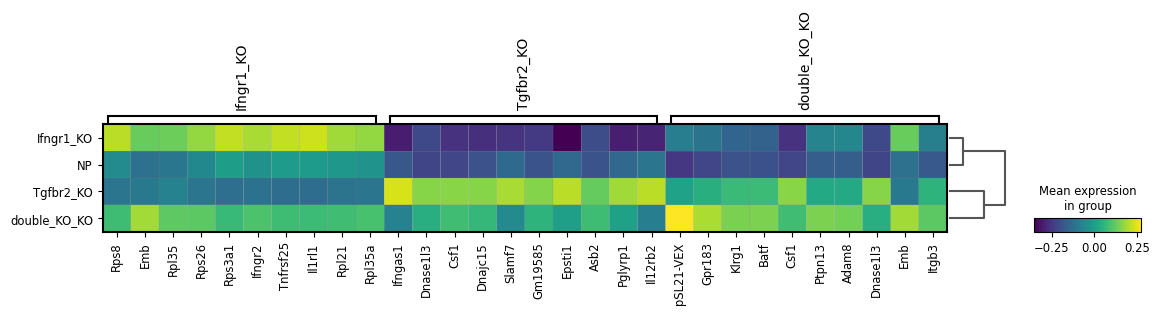

In [12]:
sc.tl.rank_genes_groups(rna, groupby="perturbation", reference="NP")
sc.pl.rank_genes_groups_matrixplot(rna)

- as seen before, ex. PAL007, normal differential analysis produces results that are pretty bad
- notice the quantity of irrelevant ribosomal genes suggesting p value inflation

## Pseudobulk approach

In [13]:
del rna.uns
del rna.varm
del rna.obsm

### Pseudobulking

In [14]:
pb = dc.get_pseudobulk(rna, sample_col="feature_call", groups_col="perturbation", layer="counts")
pb

AnnData object with n_obs × n_vars = 298 × 22953
    obs: 'feature_call', 'perturbation', 'num_features', 'guide', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    layers: 'psbulk_props'

### DE

In [15]:
dds = DeseqDataSet(
    adata = pb,
    design_factors="perturbation",
    ref_level=["perturbation", "NP"],
    refit_cooks= True,
    inference= DefaultInference(n_cpus=4)
)

dds.deseq2()

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
Fitting size factors...
... done in 0.18 seconds.

Fitting dispersions...
... done in 7.30 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 7.26 seconds.

Fitting LFCs...
... done in 5.08 seconds.

Calculating cook's distance...
... done in 0.40 seconds.

Replacing 54 outlier genes.

Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Running Wald tests...
... done in 0.99 seconds.



Log2 fold change & Wald test p-value: perturbation Ifngr1-KO vs NP
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik    0.102059        1.418920  1.640209  0.865085  0.386992   
0610006L08Rik    0.007567        1.572803  7.477976  0.210325  0.833414   
0610009B22Rik    8.797780        0.000200  0.073991  0.002698  0.997847   
0610009E02Rik    0.234988        0.997375  0.663012  1.504311  0.132501   
0610009L18Rik    4.776556       -0.015152  0.122011 -0.124188  0.901167   
...                   ...             ...       ...       ...       ...   
mt-Nd4         534.035722        0.084087  0.035484  2.369735  0.017801   
mt-Nd4l        599.861102        0.091237  0.036157  2.523314  0.011625   
mt-Nd5         492.238431        0.087472  0.036624  2.388393  0.016922   
mt-Nd6          33.386253       -0.064543  0.072751 -0.887171  0.374987   
pSL21-VEX      862.260950        0.108015  0.093109  1.160094  0.246011   

                   padj  
061000

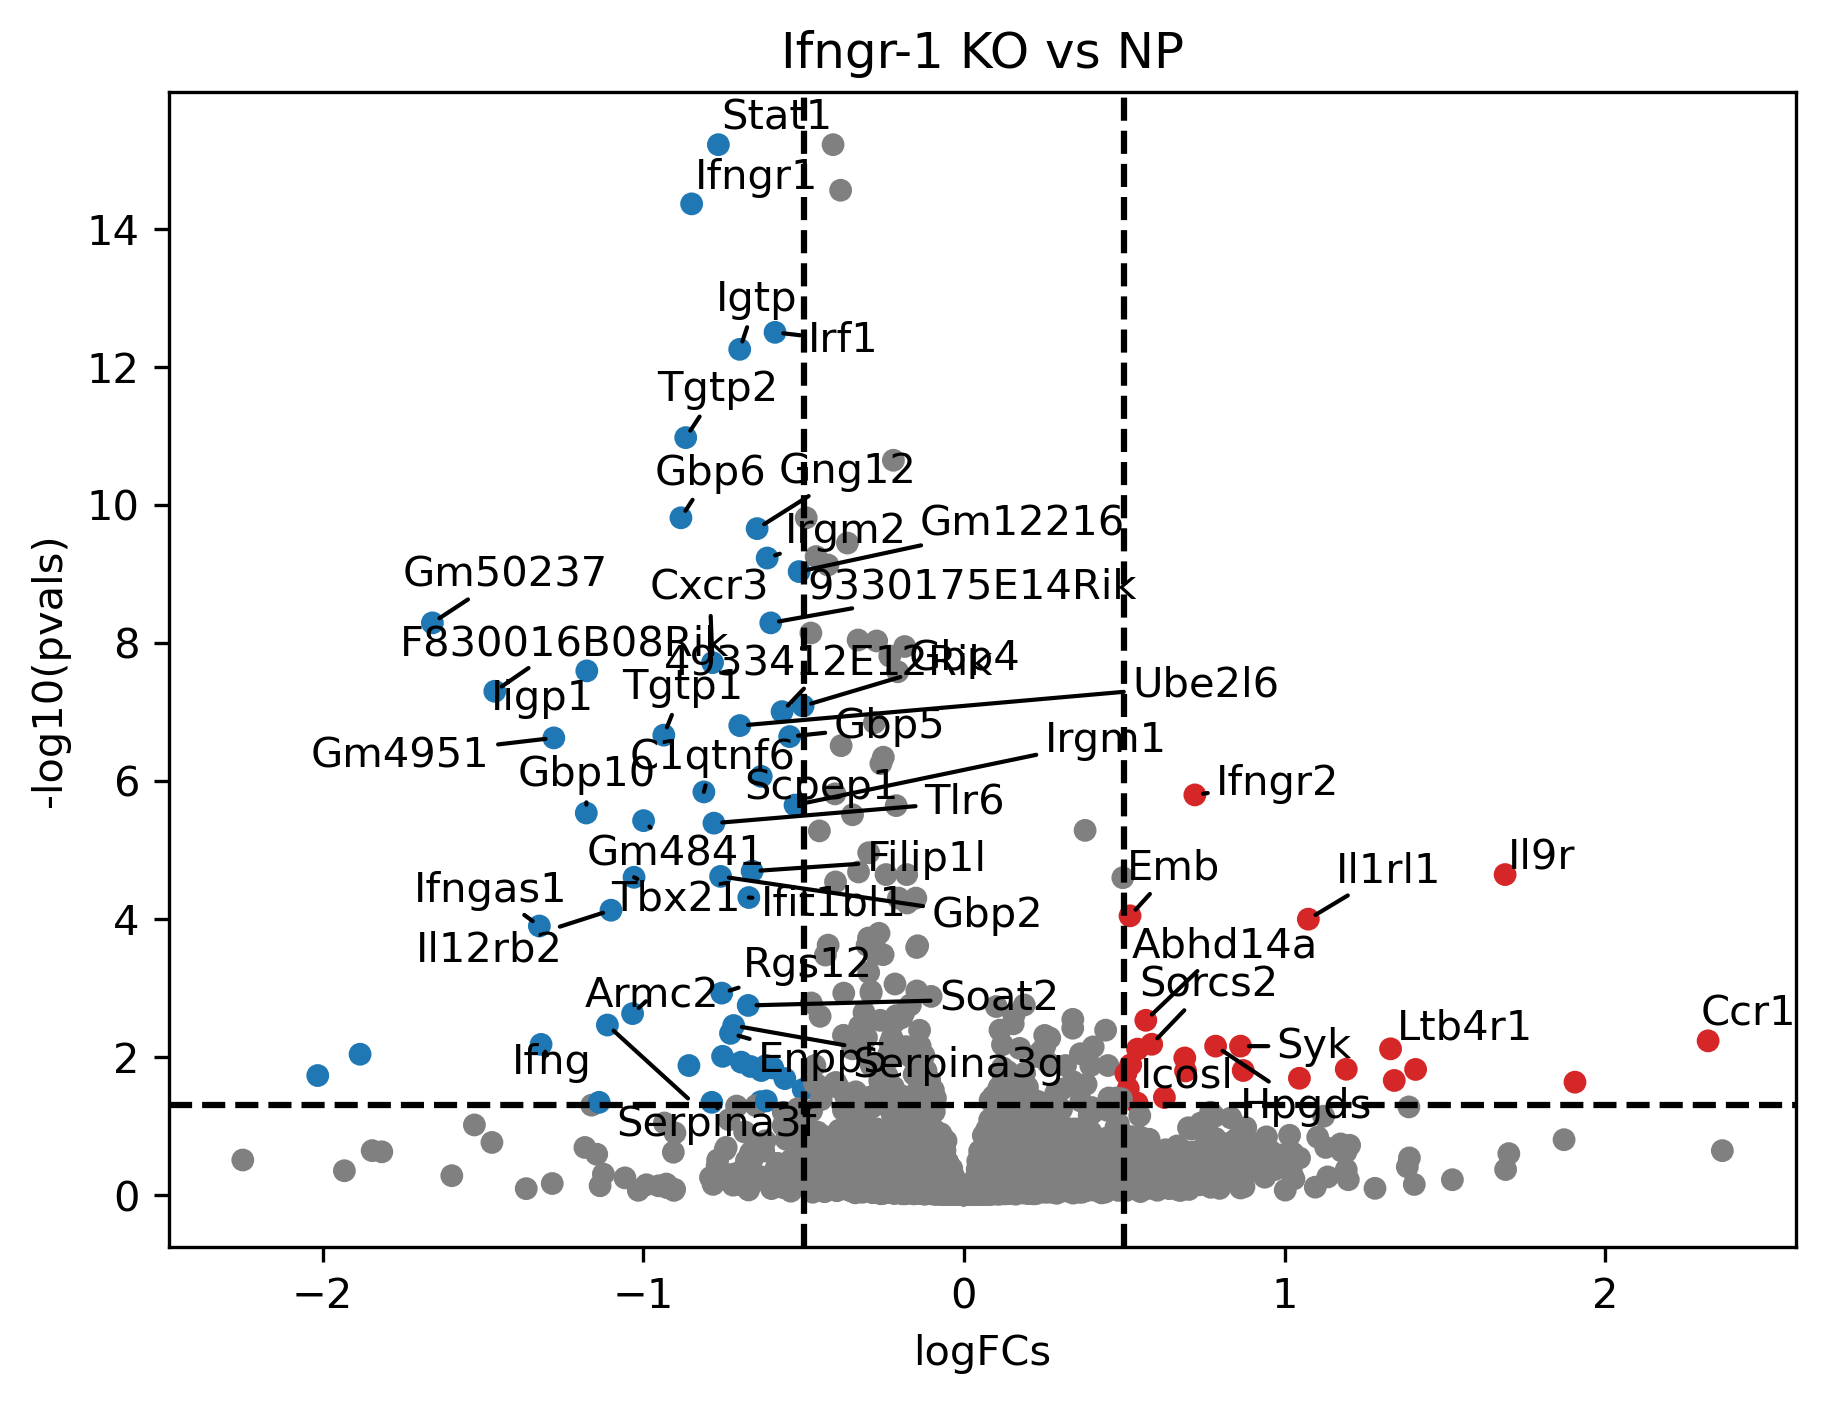

In [16]:
stat_res = DeseqStats(
    dds,
    inference=DefaultInference(n_cpus=4),
    contrast=["perturbation", "Ifngr1-KO", "NP"]
)

stat_res.summary()

iko_top = stat_res.results_df

fig = dc.plot_volcano_df(
    stat_res.results_df,
    x = "log2FoldChange",
    y="padj",
    top=50,
    return_fig=True
)

fig.axes[0].set_title("Ifngr-1 KO vs NP")

fig.set_dpi(300)

fig.show()

Running Wald tests...
... done in 0.98 seconds.



Log2 fold change & Wald test p-value: perturbation Tgfbr2-KO vs NP
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik    0.102059        0.701779  1.586643  0.442304  0.658269   
0610006L08Rik    0.007567        0.896283  7.244443  0.123720  0.901537   
0610009B22Rik    8.797780        0.092572  0.064660  1.431677  0.152236   
0610009E02Rik    0.234988        0.508132  0.630415  0.806028  0.420227   
0610009L18Rik    4.776556        0.122216  0.108794  1.123371  0.261280   
...                   ...             ...       ...       ...       ...   
mt-Nd4         534.035722       -0.059501  0.033913 -1.754514  0.079342   
mt-Nd4l        599.861102       -0.108659  0.034643 -3.136536  0.001710   
mt-Nd5         492.238431       -0.092973  0.035016 -2.655190  0.007926   
mt-Nd6          33.386253       -0.159017  0.067930 -2.340877  0.019238   
pSL21-VEX      862.260950        0.216119  0.090021  2.400756  0.016361   

                   padj  
061000

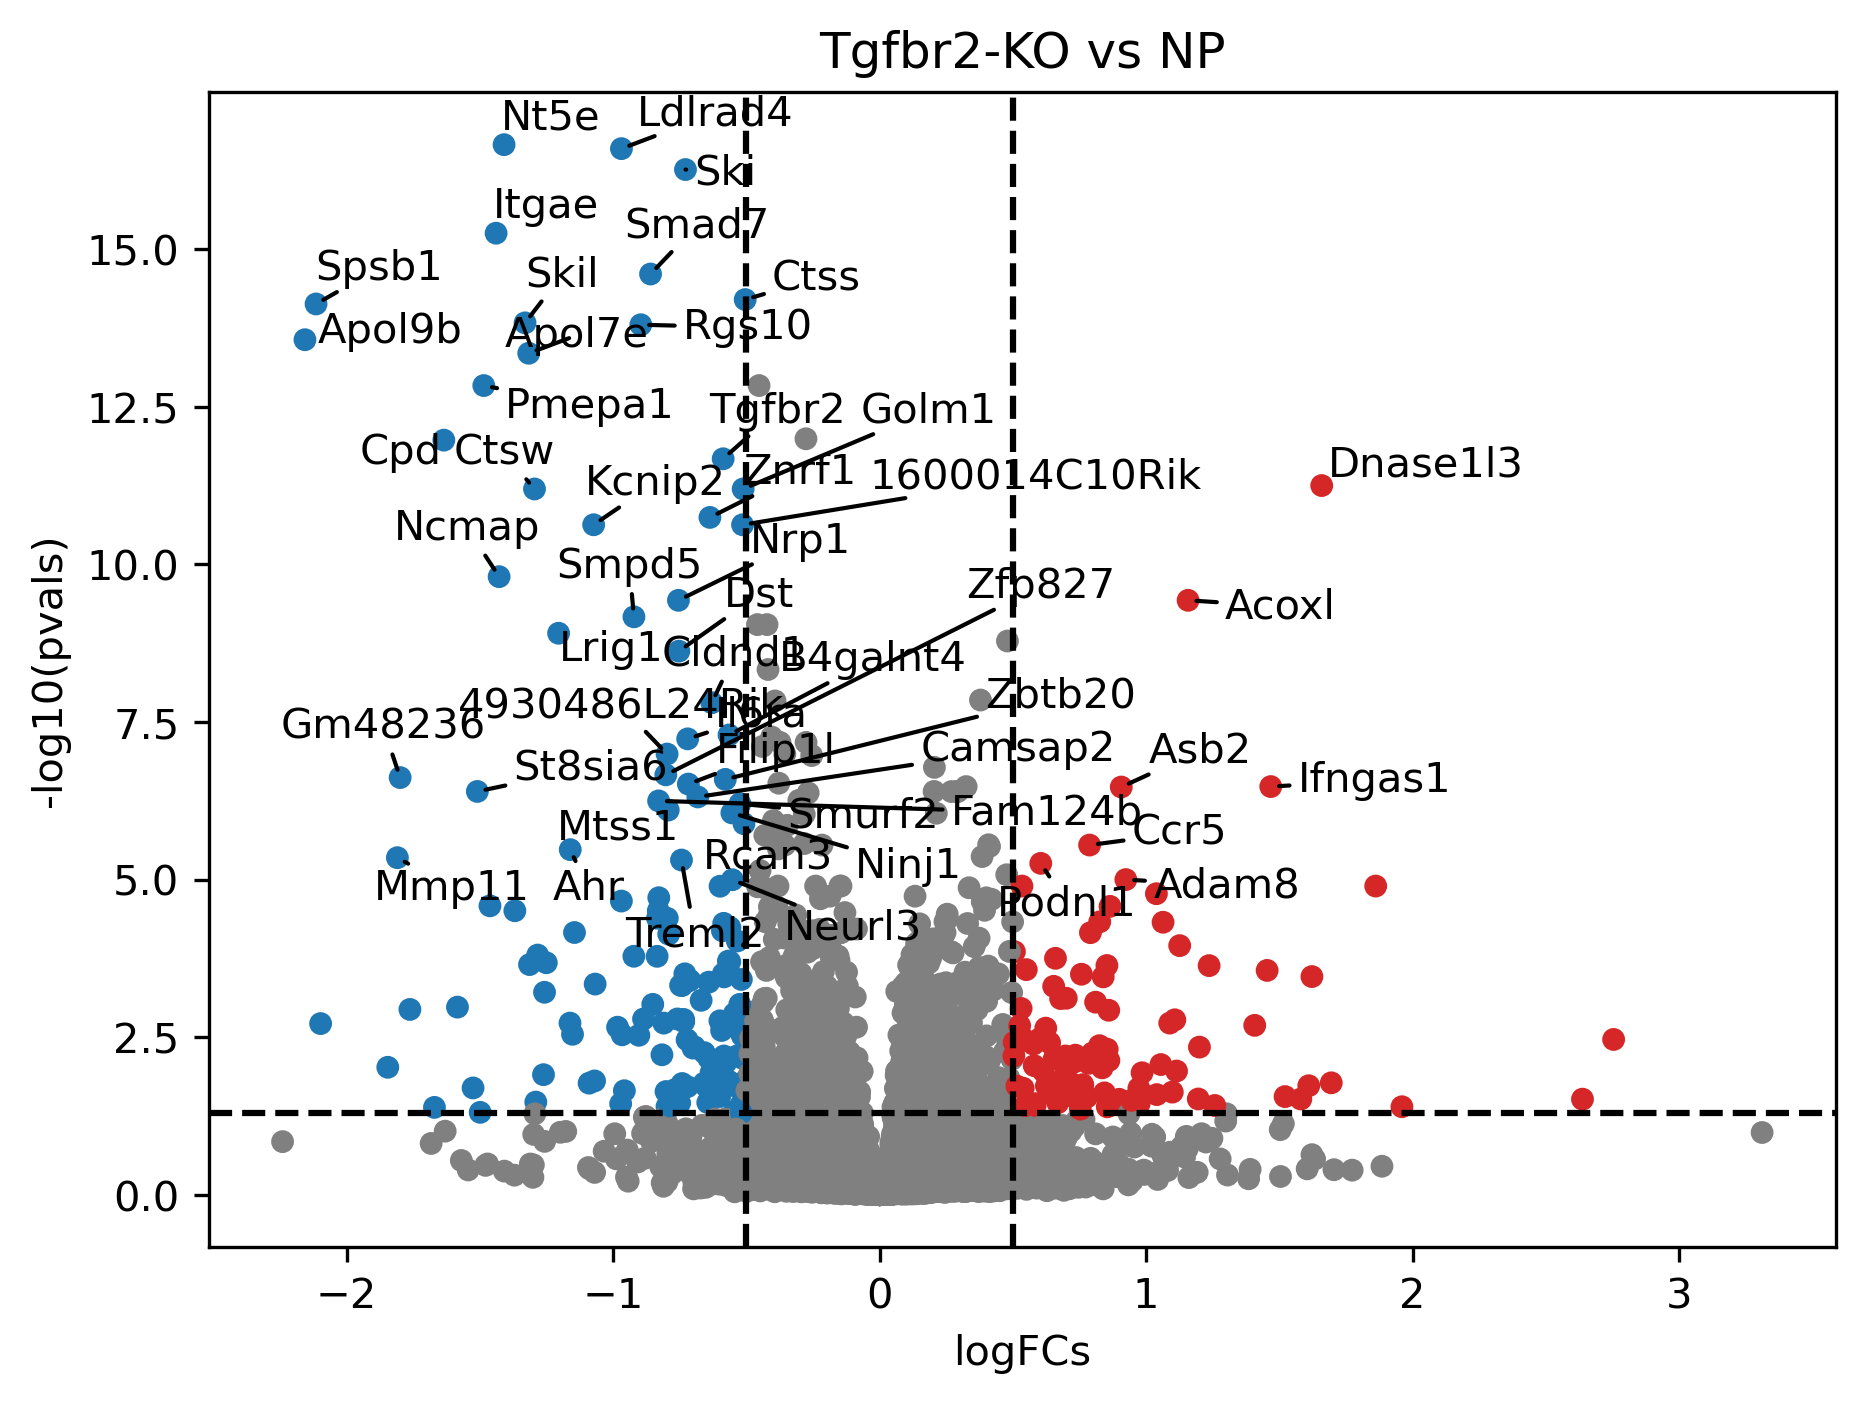

In [17]:
stat_res = DeseqStats(
    dds,
    inference=DefaultInference(n_cpus=4),
    contrast=["perturbation", "Tgfbr2-KO", "NP"]
)

stat_res.summary()

tko_top = stat_res.results_df

fig = dc.plot_volcano_df(
    stat_res.results_df,
    x = "log2FoldChange",
    y="padj",
    top=50,
    return_fig=True
)

fig.axes[0].set_title("Tgfbr2-KO vs NP")

fig.set_dpi(300)

fig.show()

Running Wald tests...
... done in 1.10 seconds.



Log2 fold change & Wald test p-value: perturbation double-KO-KO vs NP
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik    0.102059        1.436940  1.553811  0.924784  0.355078   
0610006L08Rik    0.007567        1.767668  7.092664  0.249225  0.803187   
0610009B22Rik    8.797780        0.074255  0.070401  1.054731  0.291548   
0610009E02Rik    0.234988        0.921387  0.627862  1.467498  0.142241   
0610009L18Rik    4.776556        0.090517  0.113789  0.795480  0.426335   
...                   ...             ...       ...       ...       ...   
mt-Nd4         534.035722        0.059506  0.033377  1.782833  0.074614   
mt-Nd4l        599.861102       -0.013388  0.034077 -0.392877  0.694411   
mt-Nd5         492.238431        0.045690  0.034457  1.325997  0.184841   
mt-Nd6          33.386253       -0.193249  0.068184 -2.834216  0.004594   
pSL21-VEX      862.260950        0.158469  0.088202  1.796658  0.072390   

                   padj  
061

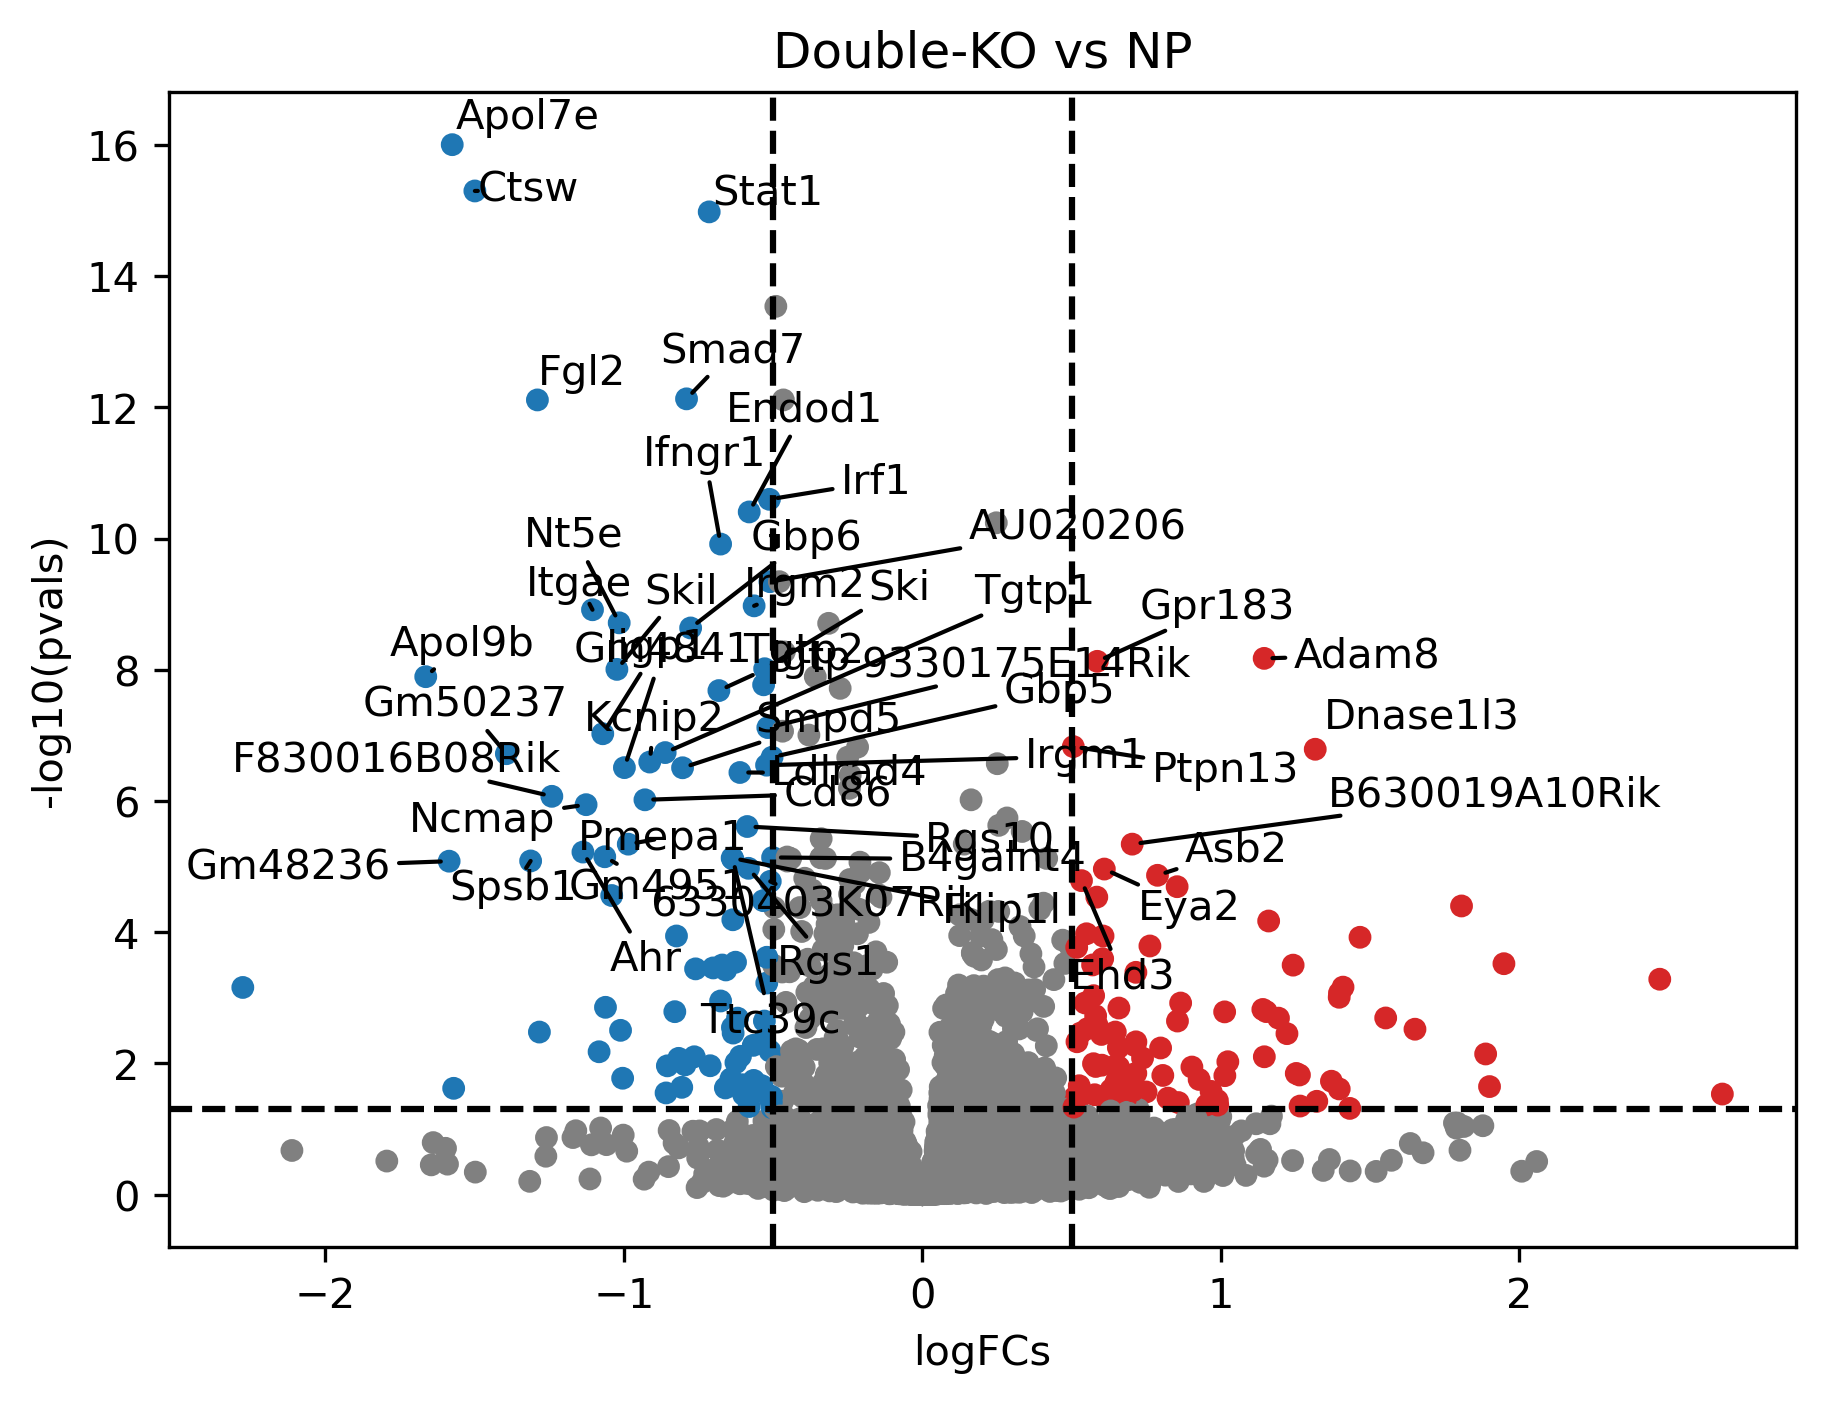

In [18]:
stat_res = DeseqStats(
    dds,
    inference=DefaultInference(n_cpus=4),
    contrast=["perturbation", "double-KO-KO", "NP"]
)

stat_res.summary()

double_top =  stat_res.results_df

fig = dc.plot_volcano_df(
    stat_res.results_df,
    x = "log2FoldChange",
    y="padj",
    top=50,
    return_fig=True
)

fig.axes[0].set_title("Double-KO vs NP")

fig.set_dpi(300)

fig.show()

### XY plots

- eric suggested doing an XY plot of the LFC for each condition against the double knockout

In [19]:
df1 = (
    iko_top
    .assign(padj = -np.log10(iko_top.padj))
    .query('padj > 1.5')
    .log2FoldChange
    .rename("iko_lfc")
)

df2 = (
    double_top
    .assign(padj = -np.log10(iko_top.padj))
    .query('padj > 1.5')
    .log2FoldChange
    .rename("double_lfc")
)

df3 = (
    tko_top
    .assign(padj = -np.log10(iko_top.padj))
    .query('padj > 1.5')
    .log2FoldChange
    .rename("tko_lfc")
)

df = pd.concat([df1, df2, df3], axis = 1).reset_index()

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: tko_vs_double.png


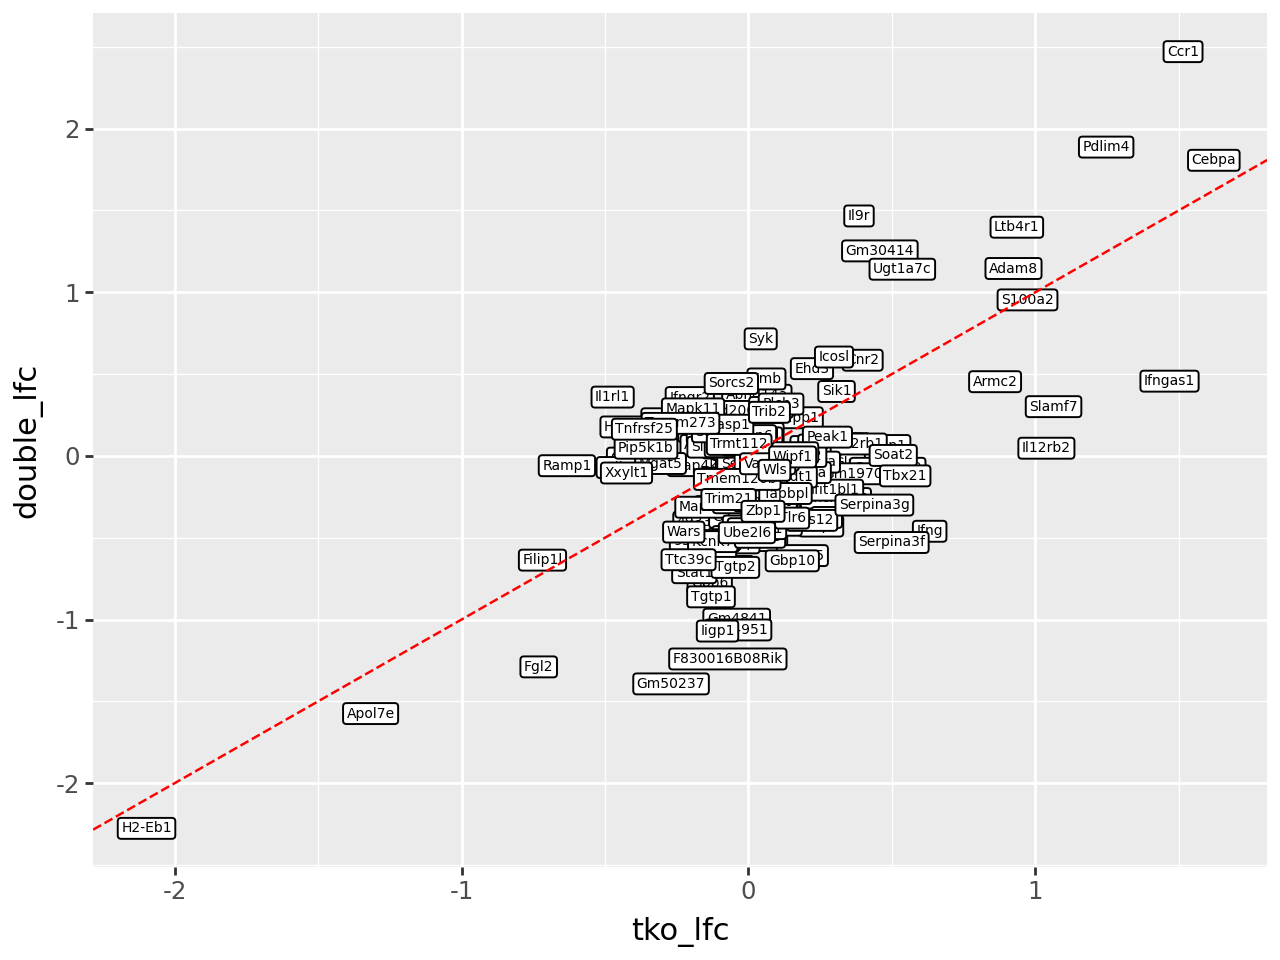

In [20]:
p = (
    p9.ggplot(df, p9.aes("tko_lfc", "double_lfc", label = "index")) +
    p9.geom_label(size = 5) +
    p9.geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed")
)

p.save("tko_vs_double.png", dpi = 300)

p

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: iko_vs_double.png


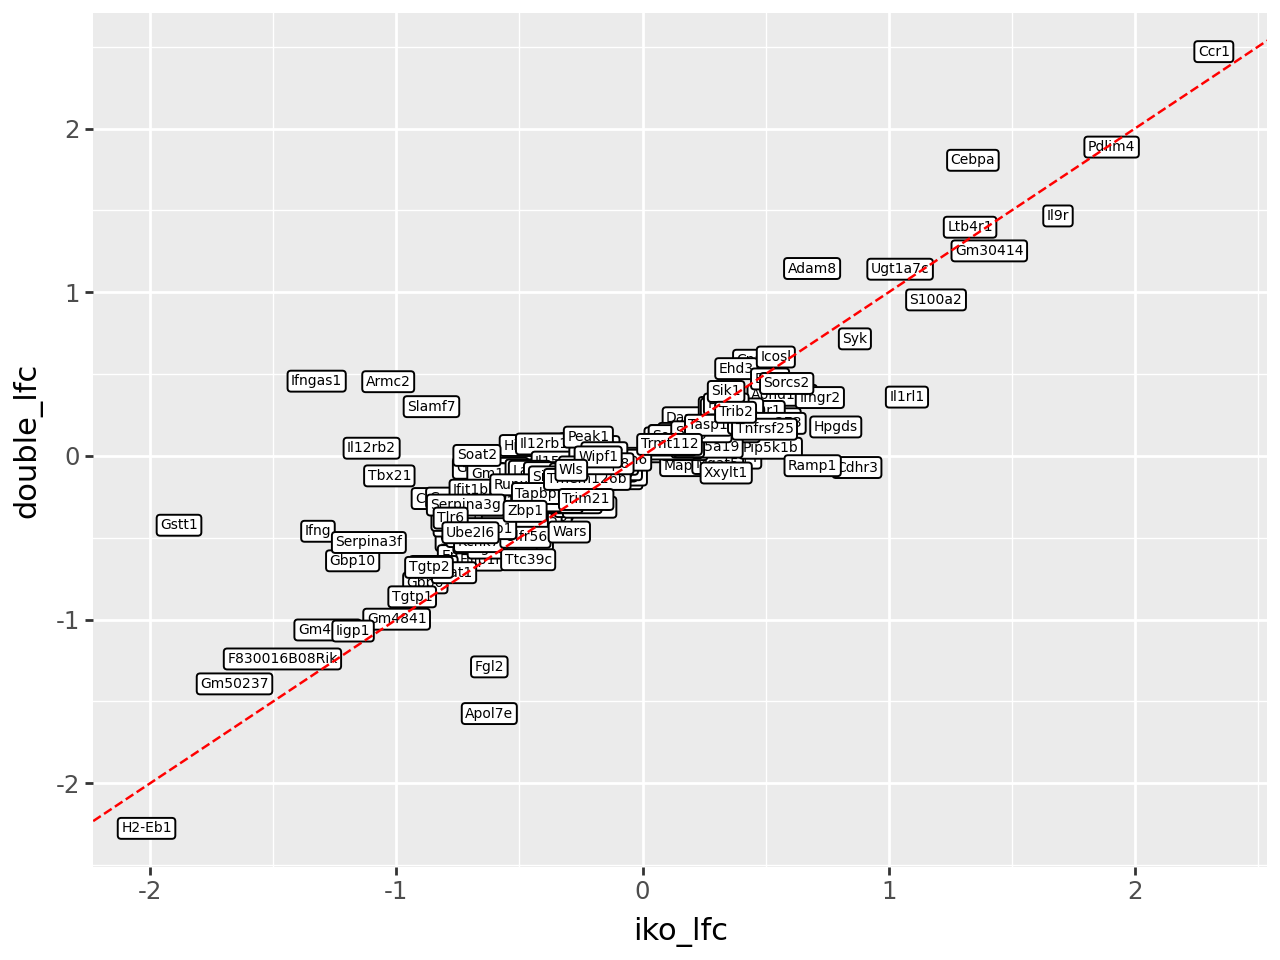

In [21]:
p = (
    p9.ggplot(df, p9.aes("iko_lfc", "double_lfc", label = "index")) +
    p9.geom_label(size = 5) +
    p9.geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed")
)

p.save("iko_vs_double.png", dpi = 300)

p

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: expected_vs_double.png


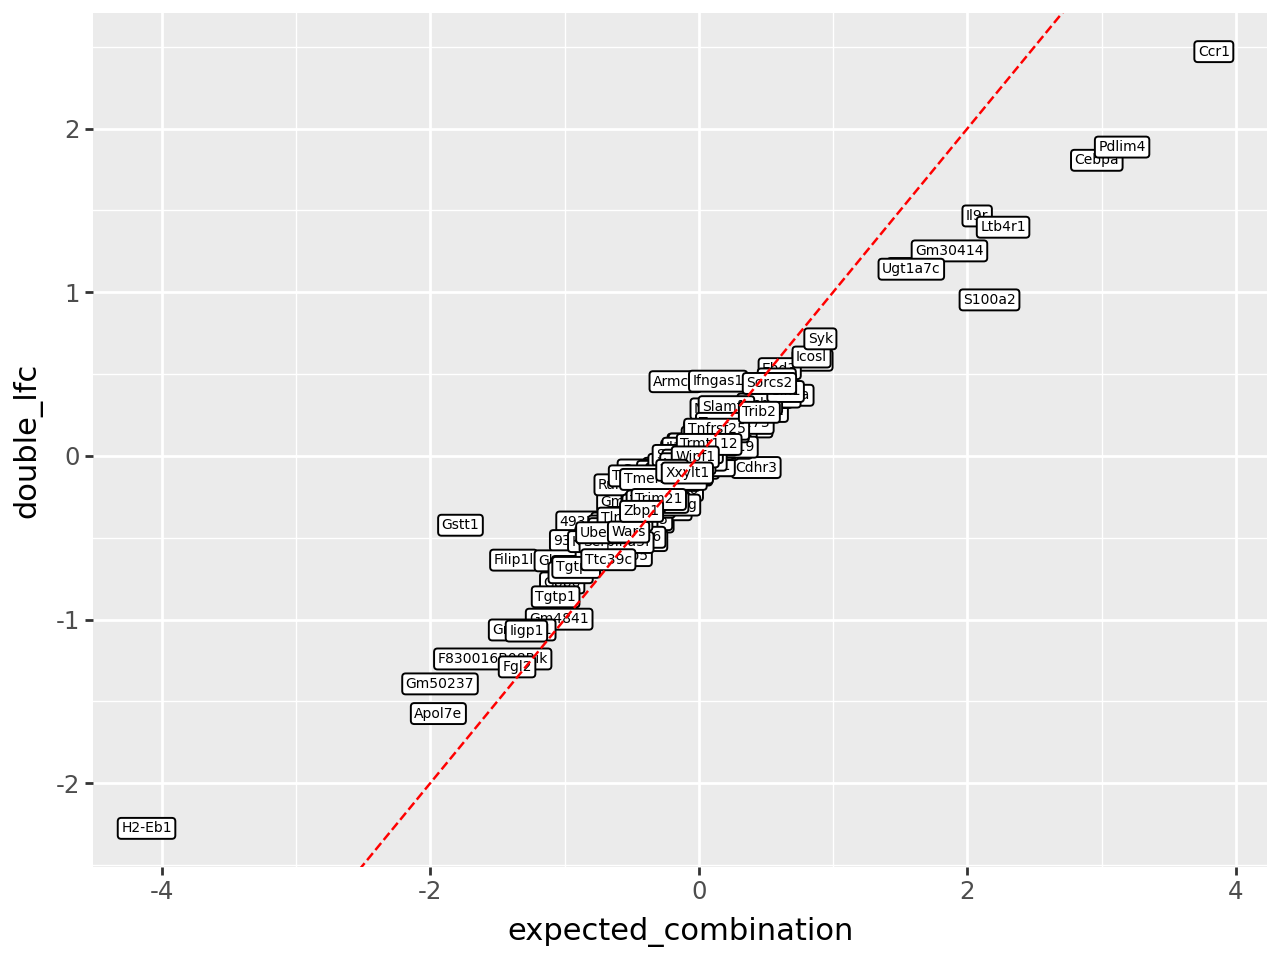

In [28]:
df["expected_combination"] = df.tko_lfc + df.iko_lfc

p = (
    p9.ggplot(df, p9.aes("expected_combination", "double_lfc", label = "index")) +
    p9.geom_label(size = 5) +
    p9.geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed")
)

p.save("expected_vs_double.png", dpi = 300)

p